Epoch 0, Loss: 1.1202
Epoch 20, Loss: 0.8180
Epoch 40, Loss: 0.8042
Epoch 60, Loss: 0.7747
Epoch 80, Loss: 0.7373


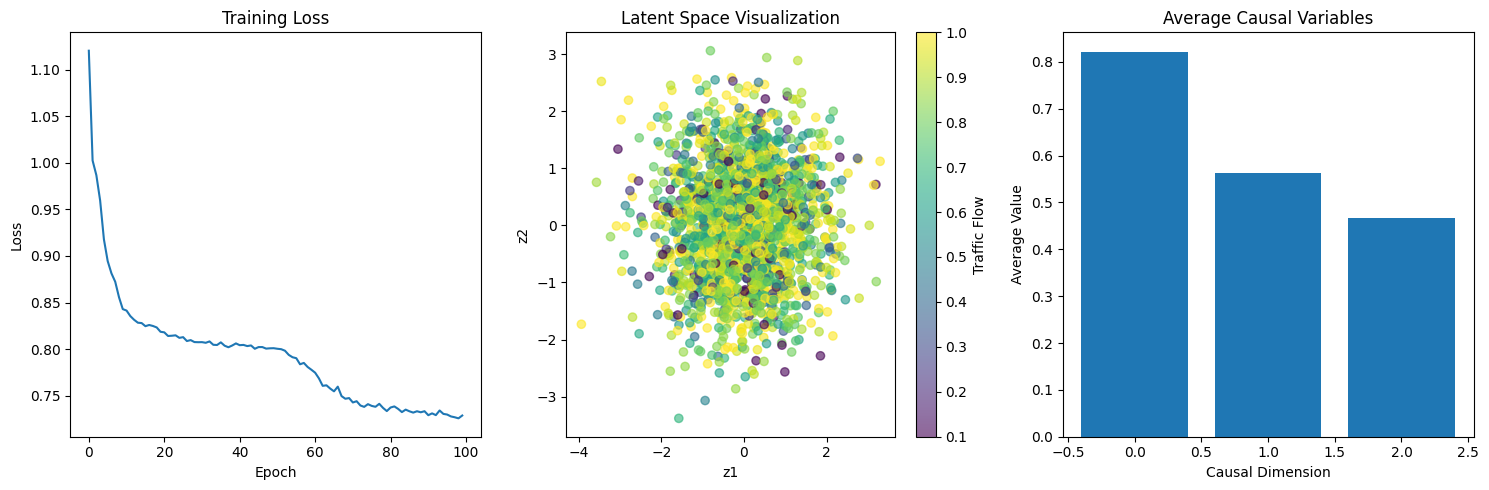


=== OoD Stability Analysis ===
OoD sample reconstruction error: 1.8586
OoD sample causal variables:
[[2.2067321e-02 3.8013589e-01 4.5699693e-04]
 [9.9999237e-01 7.1282518e-01 9.9557197e-01]]
Causal variable stability (std): 0.5435


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)

class CausalVAE(nn.Module):
    """
    Causal Latent Variable Variational Autoencoder

    Inputs:
    - input_dim: Input dimension
    - latent_dim: Latent dimension
    - causal_dim: Causal variable dimension

    Outputs:
    - Reconstructed data, latent distribution, causal variables

    Functionality:
    - Learns data generation process and extracts causal latent variables
    - Improves generation stability on OoD data
    """
    def __init__(self, input_dim=6, latent_dim=8, causal_dim=3):
        super(CausalVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Latent variable mean and log variance
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        # Causal variable extraction
        self.causal_encoder = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, causal_dim),
            nn.Sigmoid()  # Causal variables between 0-1
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + causal_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Output between 0-1
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        causal_vars = self.causal_encoder(h)
        return mu, logvar, causal_vars

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, causal_vars):
        combined = torch.cat([z, causal_vars], dim=1)
        return self.decoder(combined)

    def forward(self, x):
        mu, logvar, causal_vars = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, causal_vars)
        return recon_x, mu, logvar, causal_vars

def train_causal_vae_and_analyze_ood(data_path='fastship_data.csv'):
    """
    Train CausalVAE and analyze generation stability on OoD data

    Inputs:
    - data_path: Dataset path

    Outputs:
    - Training loss curve, latent space visualization, OoD stability analysis

    Functionality:
    - Trains causal latent variable generation model
    - Evaluates generation stability on out-of-distribution data
    """
    # Load data
    data = pd.read_csv(data_path)

    # Select numerical features for training
    feature_columns = ['time_of_day', 'weather_intensity', 'special_event',
                      'road_conditions', 'order_density', 'traffic_flow']

    # Prepare training data
    X = data[feature_columns].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_scaled)
    dataset = torch.utils.data.TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model and optimizer
    model = CausalVAE(input_dim=len(feature_columns), latent_dim=8, causal_dim=3)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Train model
    model.train()
    losses = []

    for epoch in range(100):  # Simplified number of epochs
        epoch_loss = 0
        for batch in dataloader:
            x = batch[0]
            optimizer.zero_grad()

            recon_x, mu, logvar, causal_vars = model(x)

            # Calculate loss
            recon_loss = nn.MSELoss()(recon_x, x)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            total_loss = recon_loss + 0.01 * kl_loss

            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        losses.append(epoch_loss / len(dataloader))
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss/len(dataloader):.4f}')

    # Plot training loss
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Visualize latent space
    model.eval()
    with torch.no_grad():
        # Get latent variables for all data
        mu_all, _, causal_all = model.encode(X_tensor)
        z_all = model.reparameterize(mu_all, torch.zeros_like(mu_all))  # No randomness

        # Latent variable visualization
        plt.subplot(1, 3, 2)
        plt.scatter(z_all[:, 0].numpy(), z_all[:, 1].numpy(),
                   c=data['traffic_flow'], alpha=0.6, cmap='viridis')
        plt.colorbar(label='Traffic Flow')
        plt.title('Latent Space Visualization')
        plt.xlabel('z1')
        plt.ylabel('z2')

        # Causal variable visualization
        plt.subplot(1, 3, 3)
        causal_np = causal_all.numpy()
        plt.bar(range(causal_np.shape[1]), causal_np.mean(axis=0))
        plt.title('Average Causal Variables')
        plt.xlabel('Causal Dimension')
        plt.ylabel('Average Value')

    plt.tight_layout()
    plt.show()

    # OoD stability analysis
    print("\n=== OoD Stability Analysis ===")

    # Create OoD data (extreme weather conditions)
    ood_conditions = [
        [12, 3.0, 1, 0.1, 0.8, 0.9],  # Snowstorm + event
        [3, 0.1, 0, 0.9, 0.2, 0.3],   # Late night clear sky suburban
    ]

    ood_tensor = torch.FloatTensor(scaler.transform(ood_conditions))

    with torch.no_grad():
        ood_recon, _, _, ood_causal = model(ood_tensor)
        reconstruction_error = nn.MSELoss()(ood_recon, ood_tensor)

        print(f"OoD sample reconstruction error: {reconstruction_error.item():.4f}")
        print("OoD sample causal variables:")
        print(ood_causal.numpy())

        # Calculate stability metrics
        causal_stability = torch.std(ood_causal, dim=0).mean().item()
        print(f"Causal variable stability (std): {causal_stability:.4f}")

    return model, losses

# Train CausalVAE and analyze
causal_vae_model, training_losses = train_causal_vae_and_analyze_ood()